Importy bibliotek

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
import seaborn as sns
from sklearn.metrics import hamming_loss, f1_score

Wczytanie danych, przetwarzanie i inżynieria cech

In [51]:
FILE = 'data/stan_ustalony_gotowe.csv'

# Lista cech
SELECTED_FEATURES = [
    'Active Power 1 (Cycle) [W]',
    'Reactive Power 1 (Cycle) [VAr]',
    'Power Factor 1 (Cycle) (Load)',
    'RMS - non-Fundamental I1 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]',
]

# Urzadzenia 
# Usuniete phone_charger, usb_c_charger, decoder, lamp oraz hair_dryer
# Tymczasowe usuniecie induction_cooker, mixer, toaster, spin dryer, printer, baathroom_heater, sandwich_maker
DEVICE_COLUMNS = [
    'kettle', 
    'tv',
    'coffee_maker', 
    #'immersion_heater',
    'aquarium_heater', 
    'heater',
    'laptop', 
    'christmas_tree', 
    'timer',
    'fridge', 
    'Monitor',
    'bathroom_heater',
    # 'sandwich_maker',
    # 'microwave', 
    # 'printer',
    # 'spin_dryer',
    # 'toaster',
    # 'mixer',
    # 'induction_cooker',
    # 'phone_charger', 
    # 'usb_c_charger', 
    # 'decoder', 
    #'hair_dryer'
]

# Wczytanie csv
df = pd.read_csv(FILE, sep=';', decimal=',')
df = df.iloc[:, :120]
# Usuwanie CAP/IND z Power Factor
def clean_power_factor(value):
    if isinstance(value, str):
        value = value.replace(' CAP', '').replace(' IND', '').strip()
        value = value.replace(',', '.')
    return value

# Czyszczenie powerfactor
PF_COLS = [col for col in SELECTED_FEATURES if 'Power Factor' in col]
for col in PF_COLS:
    df[col] = df[col].apply(clean_power_factor)

# Konwersja cech na typ numeryczny
for col in SELECTED_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Wiersze przed czyszczeniem
print(f"Liczba wierszy przed czyszczeniem: {len(df)}")

Liczba wierszy przed czyszczeniem: 1316


In [52]:
# Zmienne dla nowych cech
col_v = 'RMS V1N (Cycle) [V]'
col_i = 'RMS I1 (Cycle) [A]'
col_p = 'Active Power 1 (Cycle) [W]'
col_q = 'Reactive Power 1 (Cycle) [VAr]'

# Sprawdzenie czy kolumny sa numeryczne
for col in [col_v, col_i, col_p, col_q]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Moc pozorna
df['S_total_calc'] = df[col_v] * df[col_i]

# Budeanu
# Wzór: D = sqrt(S^2 - P^2 - Q^2)
term_under_sqrt = (df['S_total_calc']**2) - (df[col_p]**2) - (df[col_q]**2)
df['Budeanu Distortion Power [VAr]'] = np.sqrt(np.maximum(term_under_sqrt, 0))

# Fryze

# Konduktancja Czynna (Gw)
# Gw = P / U^2
df['Fryze_Conductance'] = df[col_p] / (df[col_v] ** 2)

# Prąd Czynny Fryzego (Iw)
# Wzór: Iw = Gw * U
df['Fryze_Active_Current'] = df['Fryze_Conductance'] * df[col_v]

# Prąd Bierny Fryzego (Ib)
# Wzór: Ib = sqrt(I_calkowite^2 - Iw^2)
df['Fryze_Passive_Current'] = np.sqrt(np.maximum(df[col_i]**2 - df['Fryze_Active_Current']**2, 0))

# Moc Bierna Fryzego (Pb)
# Wzór: Pb = sqrt(S^2 - P^2)
df['Fryze_Passive_Power'] = np.sqrt(np.maximum(df['S_total_calc']**2 - df[col_p]**2, 0))

# Nowe cechy
NEW_FEATURES = [
    'Budeanu Distortion Power [VAr]',
    'Fryze_Conductance',
    'Fryze_Active_Current',
    'Fryze_Passive_Current',
    'Fryze_Passive_Power'
]

In [53]:
# Dodanie nowych cech do juz istniejacych
for feature in NEW_FEATURES:
    if feature not in SELECTED_FEATURES:
        SELECTED_FEATURES.append(feature)
        print(f"-> Dodano nową cechę: {feature}")

print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

-> Dodano nową cechę: Budeanu Distortion Power [VAr]
-> Dodano nową cechę: Fryze_Conductance
-> Dodano nową cechę: Fryze_Active_Current
-> Dodano nową cechę: Fryze_Passive_Current
-> Dodano nową cechę: Fryze_Passive_Power

Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Budeanu Distortion Power [VAr]', 'Fryze_Conductance', 'Fryze_Active_Current', 'Fryze_Passive_Current', 'Fryze_Passive_Power']


In [6]:
# Usuniecie cech wynikajacych z teorii mocy
for feature in NEW_FEATURES:
    if feature in SELECTED_FEATURES:
        SELECTED_FEATURES.remove(feature)
        print(f"-> Usunieto ceche: {feature}")

print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

-> Usunieto ceche: Budeanu Distortion Power [VAr]
-> Usunieto ceche: Fryze_Conductance
-> Usunieto ceche: Fryze_Active_Current
-> Usunieto ceche: Fryze_Passive_Current
-> Usunieto ceche: Fryze_Passive_Power

Liczba cech: 6
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]']


In [54]:
# Zastapienie Inf/ -Inf na NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Zamiana NaN na 0
df[SELECTED_FEATURES] = df[SELECTED_FEATURES].fillna(0)

print(f"Wartości NaN/Inf zastąpiono zerami.")
print(f"Liczba wierszy: {len(df)}")

if len(df) == 0:
    raise ValueError("Zbiór danych jest pusty")

# Przygotowanie macierzy cech (X) i etykiet (y)
for col in DEVICE_COLUMNS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

X = df[SELECTED_FEATURES].values
y = df[DEVICE_COLUMNS].values

# Wydzielenie zbioru testowego
X_temp, y_temp, X_test, y_test = iterative_train_test_split(X, y, test_size=0.20)

# Wydzielenie zbioru walidacyjnego
X_train, y_train, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size=0.20)

# Standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("-" * 30)
print(f"Wymiary Trening:   {X_train_scaled.shape}, y: {y_train.shape}")
print(f"Wymiary Walidacja: {X_val_scaled.shape}, y: {y_val.shape}")
print(f"Wymiary Test:      {X_test_scaled.shape}, y: {y_test.shape}")
print(f"Liczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

Wartości NaN/Inf zastąpiono zerami.
Liczba wierszy: 1316
------------------------------
Wymiary Trening:   (841, 11), y: (841, 11)
Wymiary Walidacja: (211, 11), y: (211, 11)
Wymiary Test:      (264, 11), y: (264, 11)
Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Budeanu Distortion Power [VAr]', 'Fryze_Conductance', 'Fryze_Active_Current', 'Fryze_Passive_Current', 'Fryze_Passive_Power']


In [55]:
# Rozklad klas w zbiorach
check_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train': y_train.sum(axis=0),
    'Val': y_val.sum(axis=0),
    'Test': y_test.sum(axis=0),
    'Total': y_train.sum(axis=0) + y_val.sum(axis=0) + y_test.sum(axis=0)
})
display(check_df.sort_values(by='Train', ascending=False))

,Device,Train,Val,Test,Total
1,tv,414,104,130,648
8,fridge,251,63,78,392
5,laptop,180,44,61,285
2,coffee_maker,145,36,45,226
3,aquarium_heater,113,28,35,176
4,heater,113,30,36,179
6,christmas_tree,111,28,35,174
9,Monitor,98,24,31,153
10,bathroom_heater,84,23,27,134
7,timer,62,16,20,98


Analiza rozkładu klas (urządzeń) w zbiorach treningowych i testowych

In [56]:
def plot_multilabel_heatmap(y_true, y_pred, labels, title, cmap='viridis'):
    n_labels = len(labels)
    confusion_matrix = np.zeros((n_labels, n_labels))
    
    for i in range(n_labels):
        actual_present_mask = (y_true[:, i] == 1)
        if np.any(actual_present_mask):
            confusion_matrix[i, :] = y_pred[actual_present_mask, :].sum(axis=0)
    

    plt.figure(figsize=(14, 10))
    sns.heatmap(confusion_matrix, annot=False, fmt='.0f', cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=16)
    plt.xlabel('Przewidziane urządzenia', fontsize=12)
    plt.ylabel('Faktycznie działające urządzenia', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Random Forest

Koniec treningu Random Forest.
Exact Match (Subset Accuracy): 59.09%
F1-Score (Samples):            82.88%
F1-Score (Micro):              83.59%
Hamming Loss:                  0.0585
Raport klasyfikacji:
                 precision    recall  f1-score   support

         kettle       0.71      0.75      0.73        16
             tv       0.87      0.85      0.86       130
   coffee_maker       1.00      0.80      0.89        45
aquarium_heater       0.92      1.00      0.96        35
         heater       0.78      0.89      0.83        36
         laptop       0.62      0.54      0.58        61
 christmas_tree       0.92      1.00      0.96        35
          timer       0.73      0.95      0.83        20
         fridge       0.90      0.92      0.91        78
        Monitor       0.61      0.81      0.69        31
bathroom_heater       0.96      0.89      0.92        27

      micro avg       0.83      0.84      0.84       514
      macro avg       0.82      0.85      0.83       

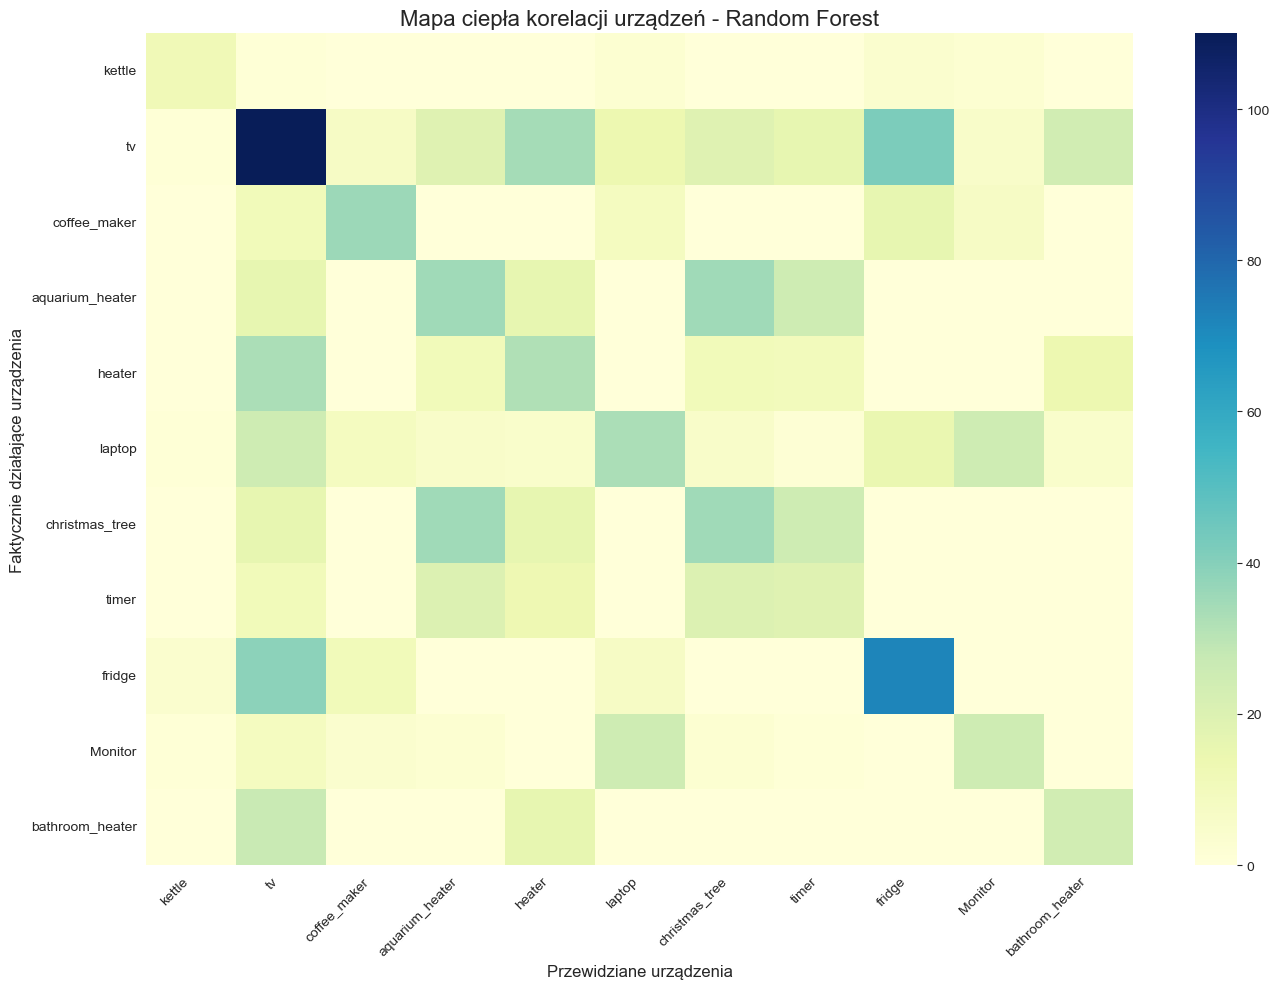

In [57]:
# Konfiguracja modelu
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model = RandomForestClassifier(
    n_estimators=320,        # większa liczba drzew
    max_depth=25,            # zmniejszona glebokosc
    min_samples_split=5,     # wezel musi miec min 5 probek do podzialu
    min_samples_leaf=2,      # lisc min 2 probki
    class_weight='balanced', # wieksze wagi dla mniejszościowych klas
    n_jobs=-1,               # Użycie wszystkich rdzeni CPU
    random_state=42
)

# Dopasowanie modelu do danych treningowych
rf_model.fit(X_train_scaled, y_train)
print("Koniec treningu Random Forest.")

# Predykcja na zbiorze testowym
y_pred = rf_model.predict(X_test_scaled)

rf_hamming = hamming_loss(y_test, y_pred)
rf_f1_samples = f1_score(y_test, y_pred, average='samples', zero_division=1)
rf_f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=1)
rf_exact_match = accuracy_score(y_test, y_pred)
print(f"Exact Match (Subset Accuracy): {rf_exact_match:.2%}")
print(f"F1-Score (Samples):            {rf_f1_samples:.2%}")
print(f"F1-Score (Micro):              {rf_f1_micro:.2%}")
print(f"Hamming Loss:                  {rf_hamming:.4f}")

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=DEVICE_COLUMNS, zero_division=0))

plot_multilabel_heatmap(
    y_test, 
    y_pred, 
    DEVICE_COLUMNS, 
    "Mapa ciepła korelacji urządzeń - Random Forest",
    cmap='YlGnBu'
)

Multi layer Perceptron (Neural Network) - TensorFlow/Keras

TensorFlow version: 2.10.0
Dostępne urządzenia: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                768       
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 11)                363       
                                                                 
Total params: 3,211
Trainable params: 3,211
Non-trainable params: 0
___

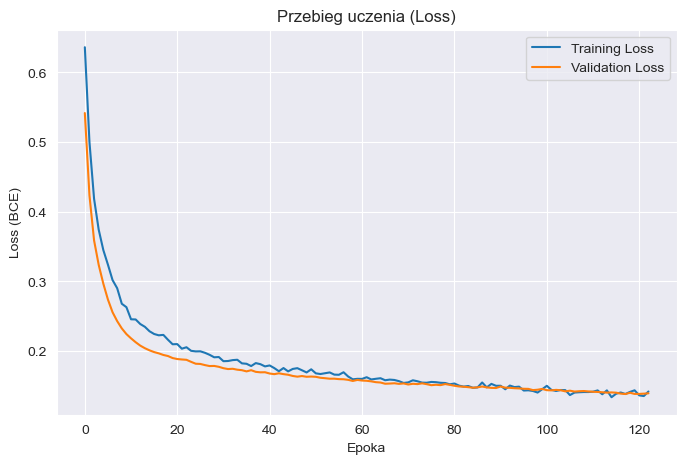

9/9 [==============================] - 0s 887us/step
Exact Match (Subset Accuracy): 47.73%
F1-Score (Samples):            77.89%
F1-Score (Micro):              78.87%
Hamming Loss:                  0.0720
Szczegółowy raport klasyfikacji:
                 precision    recall  f1-score   support

         kettle       0.92      0.69      0.79        16
             tv       0.84      0.74      0.79       130
   coffee_maker       0.94      0.76      0.84        45
aquarium_heater       0.97      1.00      0.99        35
         heater       0.94      0.81      0.87        36
         laptop       0.49      0.39      0.44        61
 christmas_tree       0.97      1.00      0.99        35
          timer       0.73      0.80      0.76        20
         fridge       0.89      0.83      0.86        78
        Monitor       0.52      0.74      0.61        31
bathroom_heater       1.00      0.81      0.90        27

      micro avg       0.82      0.76      0.79       514
      macro avg    

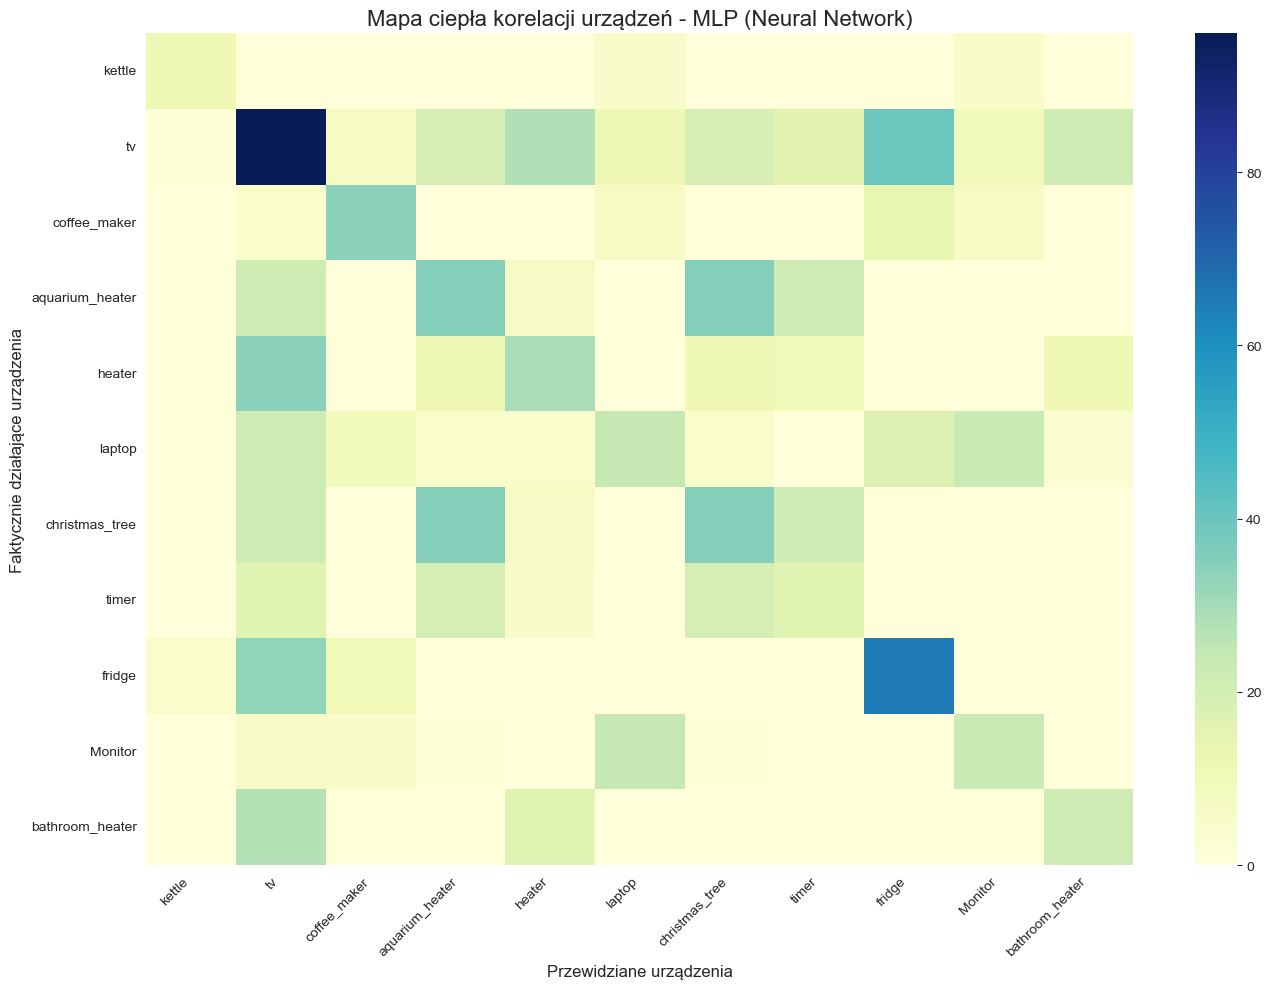

In [58]:
# Sprawdzenie dostępności GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"Dostępne urządzenia: {tf.config.list_physical_devices()}")

input_dim = X_train_scaled.shape[1]
output_dim = y_train.shape[1]

model = models.Sequential([
    # Warstwa wejściowa -> Ukryta 1
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3), 
    
    # Ukryta 1 -> Ukryta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    
    # Warstwa wyjściowa
    layers.Dense(output_dim)
])

# Wyświetlenie podsumowania architektury
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

EPOCHS = 150
BATCH_SIZE = 32

print("Rozpoczynam trening sieci neuronowej (TensorFlow)...")

history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Wykres funkcji straty
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)
plt.show()

# Predykcja zwraca "logits" (surowe wartości)
logits = model.predict(X_test_scaled)

# Konwersja logits -> prawdopodobieństwa (Sigmoid)
probs = tf.nn.sigmoid(logits).numpy()

# Binaryzacja wyników (Próg 0.5)
y_pred_numpy = (probs > 0.5).astype(int)

# Raport wyników
from sklearn.metrics import accuracy_score, classification_report
acc_dnn = accuracy_score(y_test, y_pred_numpy)

mlp_exact_match = accuracy_score(y_test, y_pred_numpy)
mlp_f1_samples = f1_score(y_test, y_pred_numpy, average='samples', zero_division=1)
mlp_f1_micro = f1_score(y_test, y_pred_numpy, average='micro', zero_division=1)
mlp_hamming = hamming_loss(y_test, y_pred_numpy)

print(f"Exact Match (Subset Accuracy): {mlp_exact_match:.2%}")
print(f"F1-Score (Samples):            {mlp_f1_samples:.2%}")
print(f"F1-Score (Micro):              {mlp_f1_micro:.2%}")
print(f"Hamming Loss:                  {mlp_hamming:.4f}")

print("Szczegółowy raport klasyfikacji:")
print(classification_report(y_test, y_pred_numpy, target_names=DEVICE_COLUMNS, zero_division=0))

plot_multilabel_heatmap(
    y_test, 
    y_pred_numpy, 
    DEVICE_COLUMNS, 
    "Mapa ciepła korelacji urządzeń - MLP (Neural Network)",
    cmap='YlGnBu'
)

In [59]:
def print_per_device_accuracy(y_true, y_pred, labels, model_name="Model"):
    print(f"\n=== Accuracy dla poszczególnych urządzeń ({model_name}) ===")
    
    accuracies = {}
    
    for i, device in enumerate(labels):
        acc = accuracy_score(y_true[:, i], y_pred[:, i])
        accuracies[device] = acc
        print(f"{device}: {acc:.2%}")
        
    return accuracies

# Accuracy poszczegylnych urządzeń dla Random Forest
print_per_device_accuracy(y_test, y_pred, DEVICE_COLUMNS, model_name="Random Forest")


# Accuracy poszczegolnych urzadzen dla MLP (Sieć Neuronowa)
print_per_device_accuracy(y_test, y_pred_numpy, DEVICE_COLUMNS, model_name="MLP")


=== Accuracy dla poszczególnych urządzeń (Random Forest) ===
kettle: 96.59%
tv: 85.98%
coffee_maker: 96.59%
aquarium_heater: 98.86%
heater: 95.08%
laptop: 81.82%
christmas_tree: 98.86%
timer: 96.97%
fridge: 94.70%
Monitor: 91.67%
bathroom_heater: 98.48%

=== Accuracy dla poszczególnych urządzeń (MLP) ===
kettle: 97.73%
tv: 80.30%
coffee_maker: 95.08%
aquarium_heater: 99.62%
heater: 96.59%
laptop: 76.52%
christmas_tree: 99.62%
timer: 96.21%
fridge: 92.05%
Monitor: 89.02%
bathroom_heater: 98.11%


{'kettle': 0.9772727272727273,
 'tv': 0.803030303030303,
 'coffee_maker': 0.9507575757575758,
 'aquarium_heater': 0.9962121212121212,
 'heater': 0.9659090909090909,
 'laptop': 0.7651515151515151,
 'christmas_tree': 0.9962121212121212,
 'timer': 0.9621212121212122,
 'fridge': 0.9204545454545454,
 'Monitor': 0.8901515151515151,
 'bathroom_heater': 0.9810606060606061}